# Evaluating Financial Machine Learning Models on Numerai

## Don't just submit and wait, evaluate!

A walkthrough to some evaluation metrics you can use for your models. 

This isn't ment to be a `Run All` notebook. I have tried to make this flexible and customizable so that you can adapt this to your workflow.

Hope this helps

You can change to GPU runtime by `Runtime > Change runtime type > GPU > Save`

## 1.0 Loading required libraries 📔 and dataset 🗄️🔽

In [1]:
!pip install numerapi
!pip install catboost;

     |████████████████████████████████| 69.2MB 45kB/s 


In [2]:
import os
import gc
import csv
import sys
import glob
import time
from pathlib import Path
from multiprocessing import Pool

import numerapi

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

In [3]:
napi = numerapi.NumerAPI(verbosity="info")
# download current dataset
napi.download_current_dataset(unzip=True)

current_ds = napi.get_current_round()
latest_round = os.path.join('numerai_dataset_'+str(current_ds))

2021-06-06 09:34:04,485 INFO numerapi.utils: starting download
./numerai_dataset_267.zip:  99%|█████████▉| 405M/407M [00:29<00:00, 16.8MB/s]2021-06-06 09:34:33,730 INFO numerapi.base_api: unzipping file...
./numerai_dataset_267.zip: 407MB [00:39, 16.8MB/s]                           

**Tournament name has been changed from "Kazutsugi" to "Nomi" but the target column has changed from "target_kazutsugi" to only "target".**

In [4]:
TOURNAMENT_NAME = "nomi"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"

BENCHMARK = 0
BAND = 0.2

#-----------------------------------------------------

# Submissions are scored by spearman correlation
def score(df):
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0, 1]


# The payout function
def payout(scores):
    return ((scores - BENCHMARK) / BAND).clip(lower=-1, upper=1)


# Read the csv file into a pandas Dataframe
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
        dtypes = {x: np.float16 for x in column_names if
                  x.startswith(('feature', 'target'))}
    return pd.read_csv(file_path, dtype=dtypes)

In [5]:
%%time
print("# Loading data...")
# The training data is used to train your model how to predict the targets.
training_data = read_csv(os.path.join(latest_round, "numerai_training_data.csv")).set_index("id")
# The tournament data is the data that Numerai uses to evaluate your model.
tournament_data = read_csv(os.path.join(latest_round, "numerai_tournament_data.csv")).set_index("id")

example_preds = read_csv(os.path.join(latest_round, "example_predictions.csv")).set_index("id")

validation_data = tournament_data[tournament_data.data_type == "validation"]


# Loading data...
CPU times: user 1min 19s, sys: 3.74 s, total: 1min 22s
Wall time: 1min 25s


In [6]:
feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")

Loaded 310 features


In [7]:
TRAIN_EVAL_PREFIX = "train"
VAL_EVAL_PREFIX = "val"

## <center>Notebook Flow</center>
<p align="center">
  <img src="https://raw.githubusercontent.com/parmarsuraj99/numerai-guides/master/better_evaluation/images/notebook_flow.png" width=40%>
</p>

---

## <center>Some simple metrics to get started</center>
<p align="center">
  <img src="https://raw.githubusercontent.com/parmarsuraj99/numerai-guides/master/better_evaluation/images/simple_stats.png" width=70%">
</p>


## 2.1 Some added metrics for evaluation 🔬

This is just to get familiar with some simpler metrics. Functions with all the metrics are in the section 2.2

In [8]:
def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def get_basic_per_era_metrics(df:pd.DataFrame, 
                        isVal=None, 
                        fig_name="per_era_scores.png") -> pd.Series:
    """
    Some metrics related to per-era scores.
    Plots per-era mean correlation with `TARGET_NAME` column
    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Parameters
    ----------
    df_with_preds : pd.DataFrame
        Training or Toutnament DataFrame having predictions assigned
        at `PREDICTION_NAME` column.

    isVal: bool, optional, default:None
    
    fig_name: str, optional, default:per_era_scores.png

    Returns:
    ------
    pd.Series: Pandas Series having 
        (mean, std, %preds<0.5, and %preds<mean(preds), corr w/ example_preds)
    
    """

    prefix=None
    #Some checks for deciding between training and tournament data
    if isVal:
        df = df[df.data_type == "validation"]
        prefix=VAL_EVAL_PREFIX
        print("predicting on validation...")
    else:
        df = df
        prefix=TRAIN_EVAL_PREFIX
        print("predicting on train...")

    #-----------------------------------------------------
    scores = pd.Series(dtype=float)
    preds_ = df[PREDICTION_NAME]
    scores[f"{prefix}_mean"] = preds_.mean()
    scores[f"{prefix}_std_dev"] = preds_.std()

    #-----------------------------------------------------
    #Metric Calculations
    print("getting per era scores")
    era_scores = df.groupby("era").apply(
        lambda x: spearmanr(x[TARGET_NAME], x[PREDICTION_NAME]))
    
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.savefig(f"{prefix}_{fig_name}")
    plt.show()

    #-----------------------------------------------------
    scores[f"{prefix}_mean correlation"] = np.mean(era_scores)
    scores[f"{prefix}_Std. Dev."] = np.std(era_scores)
    scores[f"{prefix}_sharpe"] = np.mean(era_scores)/np.std(era_scores)

    print(scores)
    del era_scores
    del preds_
    
    gc.collect()
    return scores


In [9]:
def get_all_metrics(model, 
                    feature_names:list=feature_names, 
                    fig_name="per_era_scores")->pd.Series:

    training_preds = model.predict(training_data[feature_names].values)
    training_data[PREDICTION_NAME] = np.array(training_preds).reshape(-1,1)

    tournament_preds = model.predict(tournament_data[feature_names].values)
    tournament_data[PREDICTION_NAME] = np.array(tournament_preds).reshape(-1,1)

    del training_preds
    del tournament_preds

    print("evaluating on training data...")
    tr_per_era_scores = get_basic_per_era_metrics(training_data, isVal=False, fig_name=fig_name)
    gc.collect()

    print("evaluating on validation data...")
    val_per_era_scores = get_basic_per_era_metrics(tournament_data, isVal=True, fig_name=fig_name)
    gc.collect()

    return pd.concat([
                      tr_per_era_scores, val_per_era_scores,
                      ])



### Creating some models 🤖

In [10]:
models = dict()

#Linear model
lin_reg = LinearRegression()
models["lin_reg"] = lin_reg

#Neural Net
nn_model = tf.keras.models.Sequential([
                                       tf.keras.layers.Input(shape=(310,)),
                                       tf.keras.layers.Dense(64, activation="relu"),
                                       tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model.compile(loss="mse", optimizer="adam", metrics = [tf.keras.metrics.RootMeanSquaredError()])

models["keras_mlp_simple"] = nn_model

del lin_reg
del nn_model

gc.collect()

2021-06-06 09:37:05,196 WARNING tensorflow: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


110

### Training our models⚙️

In [11]:
for model_name in models:
    print(f"Fitting {model_name}...")

    if "keras" in model_name:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values, 
             batch_size=512, 
             epochs=40,
             validation_data=(validation_data[feature_names].values, validation_data[TARGET_NAME].values),
             )
    else:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values)

    gc.collect()

Fitting lin_reg...
Fitting keras_mlp_simple...
Epoch 1/40
981/981 [==============================] - 7s 4ms/step - loss: 0.0506 - root_mean_squared_error: 0.2249 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2257
Epoch 2/40
981/981 [==============================] - 4s 4ms/step - loss: 0.0500 - root_mean_squared_error: 0.2236 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2238
Epoch 3/40
981/981 [==============================] - 4s 4ms/step - loss: 0.0499 - root_mean_squared_error: 0.2233 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2243
Epoch 4/40
981/981 [==============================] - 4s 4ms/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2237
Epoch 5/40
981/981 [==============================] - 4s 4ms/step - loss: 0.0498 - root_mean_squared_error: 0.2231 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2236
Epoch 6/40
981/981 [==============================] - 4s 4ms/step - loss: 0.0497 - root_mean_

### Evaluating models 🔬


----lin_reg----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


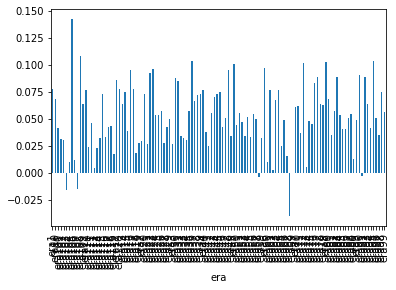

train_mean                0.500004
train_std_dev             0.011704
train_mean correlation    0.052274
train_Std. Dev.           0.030311
train_sharpe              1.724583
dtype: float64
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


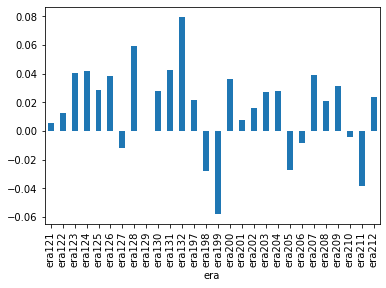

val_mean                0.500001
val_std_dev             0.011691
val_mean correlation    0.016143
val_Std. Dev.           0.029660
val_sharpe              0.544276
dtype: float64

----keras_mlp_simple----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


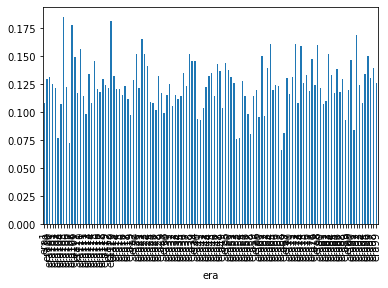

train_mean                0.496087
train_std_dev             0.032288
train_mean correlation    0.124034
train_Std. Dev.           0.022563
train_sharpe              5.497279
dtype: float64
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


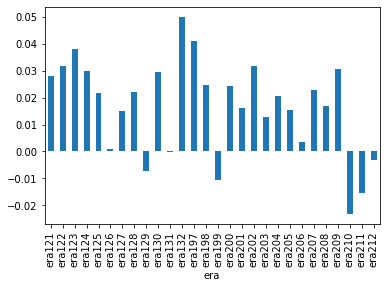

val_mean                0.497250
val_std_dev             0.033951
val_mean correlation    0.016660
val_Std. Dev.           0.017507
val_sharpe              0.951576
dtype: float64
CPU times: user 1min 37s, sys: 12 s, total: 1min 49s
Wall time: 2min 10s


In [12]:
%%time
all_model_metrics = dict()
for model_name in models:
    
    print(f"\n----{model_name}----")
    model_metrics = get_all_metrics(models[model_name], feature_names, fig_name = f"{model_name}.png")
    all_model_metrics[model_name] = model_metrics

    gc.collect()


In [13]:
metric_df = pd.DataFrame.from_dict(all_model_metrics)
metric_df

,lin_reg,keras_mlp_simple
train_mean,0.500004,0.496087
train_std_dev,0.011704,0.032288
train_mean correlation,0.052274,0.124034
train_Std. Dev.,0.030311,0.022563
train_sharpe,1.724583,5.497279
val_mean,0.500001,0.497250
val_std_dev,0.011691,0.033951
val_mean correlation,0.016143,0.016660
val_Std. Dev.,0.029660,0.017507
val_sharpe,0.544276,0.951576



- **`val_mean_correlation`** suggests how much your predictions are correlated to targets across `era`
- **`val_sharpe`** (mean/std) is for higher mean with lower std. dev.
- **`tournament_corr_example_preds`** shows how much your predictions are correlated with `example_predictions` (which have shown very good performance)

As you can see, Neural Net is showing better performance here based on these metrics. Now, let's compare Neural Net with default CatBoost model on more metrics




---

## <center>Metrics used here</center>
<p align="center">
  <img src="https://raw.githubusercontent.com/parmarsuraj99/numerai-guides/master/better_evaluation/images/all_metrics.png" width=100%">
</p>

## 2.2 Expanding the vision with more metrics 🔭

---



Do check out [More Metrics for ya](https://forum.numer.ai/t/more-metrics-for-ya/636) for community discussion

In [14]:
TRAIN_EVAL_PREFIX = "train"
VAL_EVAL_PREFIX = "val"

#Some evaluation metrics
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

#-----------------------------------------------------
def get_baisc_per_era_metrics(df:pd.DataFrame, 
                        isVal=None, 
                        fig_name="per_era_scores.png") -> pd.Series:
    """
    Some metrics related to per-era scores.
    Plots per-era mean correlation with `TARGET_NAME` column

    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Parameters
    ----------
    df_with_preds : pd.DataFrame
        Training or Toutnament DataFrame having predictions assigned
        at `PREDICTION_NAME` column.

    isVal: bool, optional, default:None
        Indication of DataFrame having Validation data. However, the 
        function checks for this is `isVal=None`. Saves checking time!
    
    fig_name: str, optional, default:per_era_scores.png
        Name for per-era correlation graph to be saved with extension.
        prefix will be added to the file name based on `data_type`.
    Returns:
    ------
    pd.Series: Pandas Series having per-era metriccs
    
    """

    prefix=None
    scores = pd.Series(dtype=float)

    preds_ = df[PREDICTION_NAME]
    #Some checks for deciding between training and tournament data
    if isVal:
        scores["tournament_corr_example_preds"] = spearmanr(preds_, example_preds[PREDICTION_NAME])
        df = df[df.data_type == "validation"]
        prefix=VAL_EVAL_PREFIX
        print("predicting on validation...")
    else:
        df = df
        prefix=TRAIN_EVAL_PREFIX
        print("predicting on train...")

    #-----------------------------------------------------

    #Metric Calculations
    print("getting per era scores")
    era_scores = df.groupby("era").apply(
        lambda x: spearmanr(x[TARGET_NAME], x[PREDICTION_NAME]))
    
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.savefig(f"{prefix}_{fig_name}")
    plt.show()

    #-----------------------------------------------------
    
    scores[f"{prefix}_mean"] = preds_.mean()
    scores[f"{prefix}_std_dev"] = preds_.std()
    scores[f"{prefix}_less_than_half"] = (preds_<0.5).mean()
    scores[f"{prefix}_less_than_mean"] = (preds_<preds_.mean()).mean()

    scores[f"{prefix}_autocorrelation"] = ar1(era_scores)
    scores[f"{prefix}_mean correlation"] = np.mean(era_scores)
    scores[f"{prefix}_Median Correlation"] = np.median(era_scores)
    scores[f"{prefix}_Variance"] = np.var(era_scores)
    scores[f"{prefix}_Std. Dev."] = np.std(era_scores)
    scores[f"{prefix}_sharpe"] = np.mean(era_scores)/np.std(era_scores)
    scores[f"{prefix}_smart sharpe"] = smart_sharpe(era_scores)
    scores[f"{prefix}_Numerai sharpe"] = numerai_sharpe(era_scores)

    print(scores)
    del era_scores
    del preds_
    gc.collect()
    return scores


In [15]:
#inspired from https://forum.numer.ai/t/more-metrics-for-ya/636 (you should definitely check out)
#and https://github.com/numerai/example-scripts/blob/master/era_boosting_example.ipynb
#and help from `MikeP`

def neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    
    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))
    gc.collect()
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    gc.collect()
    return scores / scores.std()


def calculate_feature_exposure(df, feature_names) -> list:
    exposures = []
    for feature_name in feature_names:
        exposures.append(spearmanr(df[feature_name], df[PREDICTION_NAME]))
        
    max_feat_exposure = np.max(np.abs(exposures))
    square_sum_feature_exposure = np.sum([e**2 for e in exposures])
    feature_exposure = np.std(exposures)

    #print(max_feat_exposure, square_sum_feature_exposure)

    return [feature_exposure, max_feat_exposure, square_sum_feature_exposure]


def get_more_metrics(df, feature_names, isVal=None) -> pd.Series:
    """
    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Returns basic stats about predictions in PREDICTION_NAME columns.
    It checks for training or tournament and validation predictions

    Args:
    ------
    df (pd.DataFrame): Training or Tournament DataFrame after assigning predictions
    feature_names (list): List of features to use for neutralization. (Here, all)
    isVal (bool): Boolean suggesting that df contains validation_data

    Returns:
    ------
    pd.Series: Pandas Series having 
        (var, feature_neutral_mean, feat_exposure, max_feat_exposure, 
        square_sum_feature_exposure, max_drawdown)
    """

    more_metrics = pd.Series(dtype=float)
    metric_prefix=None
    assert PREDICTION_NAME in df.columns

    if isVal is None:
        isVal = "validation" in df["data_type"].unique() #max CPU times: user 65.1 ms

    print(isVal)
    if isVal:
        df = df[df["data_type"]=="validation"]
        metric_prefix = VAL_EVAL_PREFIX
    else:
        metric_prefix = TRAIN_EVAL_PREFIX

    assert metric_prefix is not None

    #-----------------------------------------------------

    #per-era scores
    """
    per-era scores
    """
    print("predicting per-era scores...")
    scores_per_era = df.groupby("era").apply(
        lambda df: spearmanr(df[PREDICTION_NAME], df[TARGET_NAME]))
    
    more_metrics[f"{metric_prefix}_var"] = scores_per_era.std()

    #-----------------------------------------------------
    
    #Neutralize
    #This takes a significant amount of memory for calculation
    print(df.shape)
    print("Neutralizing...")
    df[f"neutral_{PREDICTION_NAME}"] = neutralize(df, PREDICTION_NAME, feature_names)
    feature_neutral_mean = df.groupby("era").apply(
        lambda x: spearmanr(x["neutral_"+PREDICTION_NAME].values, x[TARGET_NAME])).mean()

    more_metrics[f"{metric_prefix}_feature_neutral_mean"] = feature_neutral_mean
    gc.collect()

    #-----------------------------------------------------
    print("Calculating Feature Exposure...")
    feature_exposure, max_feat_exposure, square_sum_feature_exposure = calculate_feature_exposure(df, feature_names)

    more_metrics[f"{metric_prefix}_feat_exposure"] = feature_exposure
    more_metrics[f"{metric_prefix}_max_feat_exposure"] = max_feat_exposure
    more_metrics[f"{metric_prefix}_square_sum_feature_exposure"] = square_sum_feature_exposure


    #-----------------------------------------------------
    print("Drawdown...")
    rolling_max = (scores_per_era+1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (scores_per_era+1).cumprod()
    max_drawdown = (rolling_max - daily_value).max()

    more_metrics[f"{metric_prefix}_max_drawdown"] = max_drawdown

    return more_metrics

In [16]:
def get_all_metrics(model, 
                    feature_names:list=feature_names, 
                    fig_name="per_era_scores")->pd.Series:

    training_preds = model.predict(training_data[feature_names].values)
    training_data[PREDICTION_NAME] = np.array(training_preds).reshape(-1,1)

    tournament_preds = model.predict(tournament_data[feature_names].values)
    tournament_data[PREDICTION_NAME] = np.array(tournament_preds).reshape(-1,1)

    del training_preds
    del tournament_preds

    print("evaluating on training data...")
    tr_per_era_scores = get_baisc_per_era_metrics(training_data, isVal=False, fig_name=fig_name)
    tr_more_metrics = get_more_metrics(training_data, feature_names ,isVal=False)
    gc.collect()

    print("evaluating on validation data...")
    val_per_era_scores = get_baisc_per_era_metrics(tournament_data, isVal=True, fig_name=fig_name)
    val_more_metrics = get_more_metrics(tournament_data, feature_names ,isVal=True)
    gc.collect()

    return pd.concat([
                      tr_per_era_scores, val_per_era_scores,
                      tr_more_metrics, val_more_metrics,
                      ])
    

### Creating some models 🤖

In [17]:
models = dict()

#CatBoost Regressor
cat_reg_params = {
    'task_type': 'GPU'
    }
cat_regressor = CatBoostRegressor(**cat_reg_params)
models["cat_reg"] = cat_regressor

#Neural Net
nn_model = tf.keras.models.Sequential([
                                       tf.keras.layers.Input(shape=(310,)),
                                       tf.keras.layers.Dense(64, activation="relu"),
                                       tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model.compile(loss="mse", optimizer="adam", metrics = [tf.keras.metrics.RootMeanSquaredError()])

models["keras_mlp_simple"] = nn_model

del cat_regressor
del nn_model
gc.collect()

2021-06-06 09:42:57,034 WARNING tensorflow: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


1337

### Training our models⚙️

In [18]:
for model_name in models:
    print(f"Fitting {model_name}...")

    if "keras" in model_name:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values, 
             batch_size=512, 
             epochs=40,
             validation_data=(validation_data[feature_names].values, validation_data[TARGET_NAME].values),
             )
    else:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values)

    gc.collect()

Fitting cat_reg...
Learning rate set to 0.089182
0:	learn: 0.2232632	total: 44.3ms	remaining: 44.3s
1:	learn: 0.2232581	total: 69.6ms	remaining: 34.7s
2:	learn: 0.2232510	total: 96.3ms	remaining: 32s
3:	learn: 0.2232462	total: 122ms	remaining: 30.3s
4:	learn: 0.2232427	total: 149ms	remaining: 29.6s
5:	learn: 0.2232376	total: 175ms	remaining: 29s
6:	learn: 0.2232312	total: 205ms	remaining: 29s
7:	learn: 0.2232225	total: 233ms	remaining: 28.9s
8:	learn: 0.2232165	total: 260ms	remaining: 28.7s
9:	learn: 0.2232089	total: 284ms	remaining: 28.1s
10:	learn: 0.2232032	total: 310ms	remaining: 27.8s
11:	learn: 0.2231993	total: 335ms	remaining: 27.6s
12:	learn: 0.2231939	total: 359ms	remaining: 27.3s
13:	learn: 0.2231904	total: 389ms	remaining: 27.4s
14:	learn: 0.2231801	total: 411ms	remaining: 27s
15:	learn: 0.2231762	total: 434ms	remaining: 26.7s
16:	learn: 0.2231726	total: 457ms	remaining: 26.4s
17:	learn: 0.2231691	total: 484ms	remaining: 26.4s
18:	learn: 0.2231646	total: 506ms	remaining: 26.

### Evaluating models 🔭


----cat_reg----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


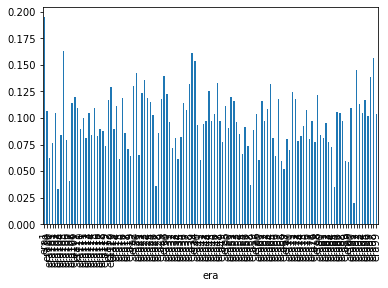

2021-06-06 09:51:26,139 INFO numexpr.utils: NumExpr defaulting to 2 threads.


train_mean                   0.499997
train_std_dev                0.008087
train_less_than_half         0.499960
train_less_than_mean         0.499743
train_autocorrelation        0.143338
train_mean correlation       0.096568
train_Median Correlation     0.096883
train_Variance               0.000848
train_Std. Dev.              0.029120
train_sharpe                 3.316219
train_smart sharpe           2.862026
train_Numerai sharpe        10.248736
dtype: float64
False
predicting per-era scores...
(501808, 314)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


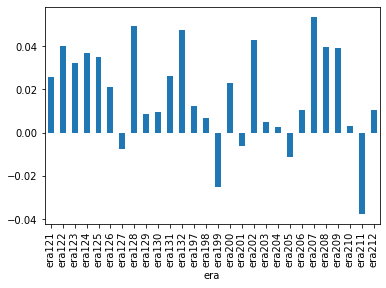

tournament_corr_example_preds    0.525195
val_mean                         0.500050
val_std_dev                      0.008175
val_less_than_half               0.497253
val_less_than_mean               0.500160
val_autocorrelation              0.146547
val_mean correlation             0.017691
val_Median Correlation           0.016889
val_Variance                     0.000509
val_Std. Dev.                    0.022552
val_sharpe                       0.784482
val_smart sharpe                 0.668213
val_Numerai sharpe               1.117687
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----keras_mlp_simple----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


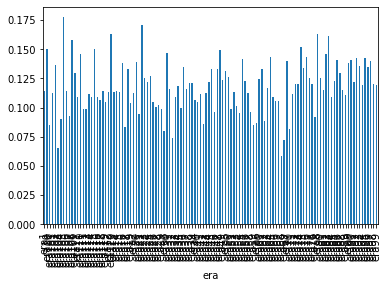

train_mean                   0.497425
train_std_dev                0.028550
train_less_than_half         0.645424
train_less_than_mean         0.402361
train_autocorrelation        0.011655
train_mean correlation       0.118086
train_Median Correlation     0.115592
train_Variance               0.000485
train_Std. Dev.              0.022034
train_sharpe                 5.359354
train_smart sharpe           5.275646
train_Numerai sharpe        16.927890
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


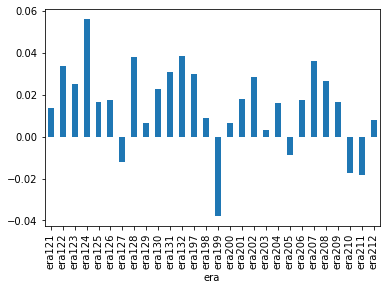

tournament_corr_example_preds    0.340231
val_mean                         0.498701
val_std_dev                      0.029475
val_less_than_half               0.639169
val_less_than_mean               0.435394
val_autocorrelation              0.229773
val_mean correlation             0.015015
val_Median Correlation           0.017079
val_Variance                     0.000401
val_Std. Dev.                    0.020015
val_sharpe                       0.750191
val_smart sharpe                 0.588122
val_Numerai sharpe               0.796131
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...
CPU times: user 10min 20s, sys: 25 s, total: 10min 45s
Wall time: 8min 48s


In [19]:
%%time
all_model_metrics = dict()
for model_name in models:
    
    print(f"\n----{model_name}----")
    model_metrics = get_all_metrics(models[model_name], feature_names, fig_name = f"{model_name}.png")
    all_model_metrics[model_name] = model_metrics
    
    gc.collect()
    

In [20]:
metric_df = pd.DataFrame.from_dict(all_model_metrics)
metric_df

,cat_reg,keras_mlp_simple
train_mean,0.499997,0.497425
train_std_dev,0.008087,0.028550
train_less_than_half,0.499960,0.645424
train_less_than_mean,0.499743,0.402361
train_autocorrelation,0.143338,0.011655
train_mean correlation,0.096568,0.118086
train_Median Correlation,0.096883,0.115592
train_Variance,0.000848,0.000485
train_Std. Dev.,0.029120,0.022034
train_sharpe,3.316219,5.359354


### Let's Compare these models aginst `example_predictions`

predicting on validation...
getting per era scores
performance over time


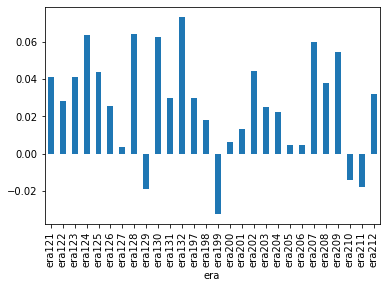

tournament_corr_example_preds    0.966433
val_mean                         0.500443
val_std_dev                      0.012602
val_less_than_half               0.497387
val_less_than_mean               0.512503
val_autocorrelation              0.005054
val_mean correlation             0.026577
val_Median Correlation           0.028823
val_Variance                     0.000742
val_Std. Dev.                    0.027240
val_sharpe                       0.975675
val_smart sharpe                 0.953436
val_Numerai sharpe               2.055345
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...


In [21]:
tournament_data[PREDICTION_NAME] = example_preds.values.reshape(-1, 1)

example_val_per_era_scores = get_baisc_per_era_metrics(tournament_data, isVal=True, fig_name="example_preds")
example_val_more_metrics = get_more_metrics(tournament_data, feature_names ,isVal=True)

example_preds_metrics = pd.concat([example_val_per_era_scores, example_val_more_metrics])

In [22]:
metric_df["example_preds"] = example_preds_metrics

In [23]:
metric_df

,cat_reg,keras_mlp_simple,example_preds
train_mean,0.499997,0.497425,NaN
train_std_dev,0.008087,0.028550,NaN
train_less_than_half,0.499960,0.645424,NaN
train_less_than_mean,0.499743,0.402361,NaN
train_autocorrelation,0.143338,0.011655,NaN
train_mean correlation,0.096568,0.118086,NaN
train_Median Correlation,0.096883,0.115592,NaN
train_Variance,0.000848,0.000485,NaN
train_Std. Dev.,0.029120,0.022034,NaN
train_sharpe,3.316219,5.359354,NaN


In [24]:
#Go ahead and use these to improve your models

## Model for your submission

Left as an exercise to the reader 😉

▶️ Visit [An easy guide to “The hardest data science tournament on the planet”](https://towardsdatascience.com/a-guide-to-the-hardest-data-science-tournament-on-the-planet-748f46e83690) to get started with how to make your submissions directly from colab.



In [25]:
#Train and evaluate your model for submission


## Uploading predictions using your API keys 🚀

In [26]:
tournament_data[PREDICTION_NAME].to_csv(f"{TOURNAMENT_NAME}_{current_ds}_submission.csv")

In [27]:
# NameOfYourAI
public_id = "YourKeys"
secret_key = "YourKeys"
model_id = "YourKeys"
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)

In [28]:
submission_id = napi.upload_predictions(f"{TOURNAMENT_NAME}_{current_ds}_submission.csv", model_id=model_id)

2021-06-06 09:56:18,831 INFO numerapi.base_api: uploading predictions...
2021-06-06 09:56:19,144 ERROR numerapi.base_api: Your session is invalid or has expired.


ValueError: ignored



---


# Whats Next? 💭
 - **Customize this according to your workflow**
 - Read about [MMC](https://docs.numer.ai/tournament/metamodel-contribution)
 - Connect on [RocketChat](https://community.numer.ai/) or [Forum](https://forum.numer.ai/)
 - Take some help from [analysis_and_tips.ipynb](https://github.com/numerai/example-scripts/blob/master/analysis_and_tips.ipynb) notebook
 - Read this topic on forum about  metrics - ["More Metrics for ya" ](https://forum.numer.ai/t/more-metrics-for-ya/636)
 - Read and try to join the [weekly Office Hours](https://docs.numer.ai/office-hours-with-arbitrage/office-hours-recaps/ohwa-1) \(I was interviewed [OHwA S02E10](https://docs.numer.ai/office-hours-with-arbitrage/office-hours-recaps-season-2/ohwa-s02e10) 😃)


Found any mistakes? Please let me know.

Created by Suraj Parmar

- Numerai: [SurajP](https://numer.ai/surajp)

- Twitter: [@parmarsuraj99](https://twitter.com/parmarsuraj99)


Thanks to [@NJ](https://twitter.com/tasha_jade) and [@MikeP](https://twitter.com/EasyMikeP) for feedbacks.